# Finding $H_2$ Ground State Energy using Trotterization

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
import cirq
import numpy             as np
import matplotlib.pyplot as plt

from cirq.contrib         import qasm_import
from openfermion          import jordan_wigner
from openfermion.chem     import MolecularData
from openfermion.circuits import trotterize_exp_qubop_to_qasm

from pyLIQTR.utils.utils  import open_fermion_to_qasm


## Setup the Hamiltonian
We will use $H_2$ as a test case due to the molecule's simplicity.

<b>Note:</b> To demonstrate how to generate a GSE circuit to calculate the properties of the $H_2$ molecule using <i>pyLIQTR</i>, we will load a pre-generated molecular hamiltonian using openfermion. The cell below demonstrates how to do so.

In [2]:
### 
### Define the file that holds the molecular hamiltoninan
###
file_name = 'H2_Molecule.hdf5'

molecule = MolecularData(filename=file_name)

###
### Load the molecule:
###
molecule.load()

###
### Get the molecular hamiltonian, which is an openfermion object
###
mol_ham = molecule.get_molecular_hamiltonian()

###
### Output some information to the screen:
###
print(f'> GS energy   = {molecule.hf_energy}')
print(f'> n electrons = {molecule.n_electrons}')
print(f'> n orbitals  = {molecule.n_orbitals}')
print(f'> n qubits    = {mol_ham.n_qubits}')

> GS energy   = -1.116684387085341
> n electrons = 2
> n orbitals  = 2
> n qubits    = 4


In [3]:
###
### Now apply the Jordan-Wigner transform to the molecular hamiltonian
###
### Note: this is an openfermion function
###
jw_ham = jordan_wigner(mol_ham)

In [4]:
###
### Now Trotterize and convert to a unitary matrix
### using a combination of functions from
###   - openfermion
###   - cirq
###   - pyLIQTR
###

###
### Note: Trotter parameters impact the downstream calculation.
### Set them here:
###
trotter_order = 1
trotter_steps = 1

###
### Number of qubits is set by the problem.
### H_2 has 4 orbitals which each require 
### a qubit, and a 5th qubit is needed
### to measure the precision bits.
###
num_qubits = 5

###
### Need factor of 2 here due to convention used 
### in openfermion implementation of trotterization.
### 
### Note, keep evolution_time=1 to simplify the 
### conversion between phi and E_n, as discussed
### below.
### 
jw_ham_trotterized_generator = trotterize_exp_qubop_to_qasm(-jw_ham*2, evolution_time=1, trotter_number=trotter_steps, trotter_order=trotter_order)
jw_ham_trotterized_circuit   = open_fermion_to_qasm(num_qubits, jw_ham_trotterized_generator, reg_name='reg') 
tmp_circuit                  = qasm_import.circuit_from_qasm(jw_ham_trotterized_circuit)

###
### Convert circuit to unitary dense matrix:
###

trotterized_unitary = cirq.unitary(tmp_circuit)

# uwai_sparse = sparse.csr_matrix(unitary_we_are_implementing)
# uwai_sparse.data = np.round(uwai_sparse.data,4)
# print(uwai_sparse)

## Diagonalization
Now diagonalize the trotterized unitary matrix and calculate the ground state properties.

Note, the eigenvalues from the diagonalization of the trotterized matrix will not actually be $H_2$ energies. This is because we are calculating the eigenvalues of 
$$
e^{-iHt} = e^{-E_{n}t} = e^{-2\pi i \phi}
$$

If we say that the eigenvalues of $e^{-iHt}$ are defined as $\chi_n$, we can see that to determine the associated energies, $E_n$ we do the following:
$$
E_n = imag(ln(\chi_n))
$$

Note: if $t\neq1$ then more care must be taken.


In [5]:
###
### Get the eigenvalues and eigenvectors by diagonalization:
###
e_values, e_vectors = np.linalg.eig(trotterized_unitary)

###
### Sort the eigenvalues. Print the GSE, and the accompanying 
### eigenstate
###
sorted_e_values       = np.sort_complex(e_values)
ground_state_e_value  = sorted_e_values[0]
gs_evalue_idx         = np.where(e_values==ground_state_e_value)
ground_state_e_vector = e_vectors[:, gs_evalue_idx[0][0]]
ground_state_energy   = np.log(ground_state_e_value).imag

print(f'> The ground state phi is: {ground_state_e_value.real:0.4f}') # Note, this should be 100% real, but is formatted complex.
print(f'> The ground state energy is: {ground_state_energy}')
print(f'> The ground state is {cirq.dirac_notation(np.transpose(ground_state_e_vector.real).tolist(),4)}')

> The ground state phi is: 0.5114
> The ground state energy is: -1.0339948573878062
> The ground state is -0.089|0011⟩ + 0.992|1100⟩


(-1.5, 2.0)

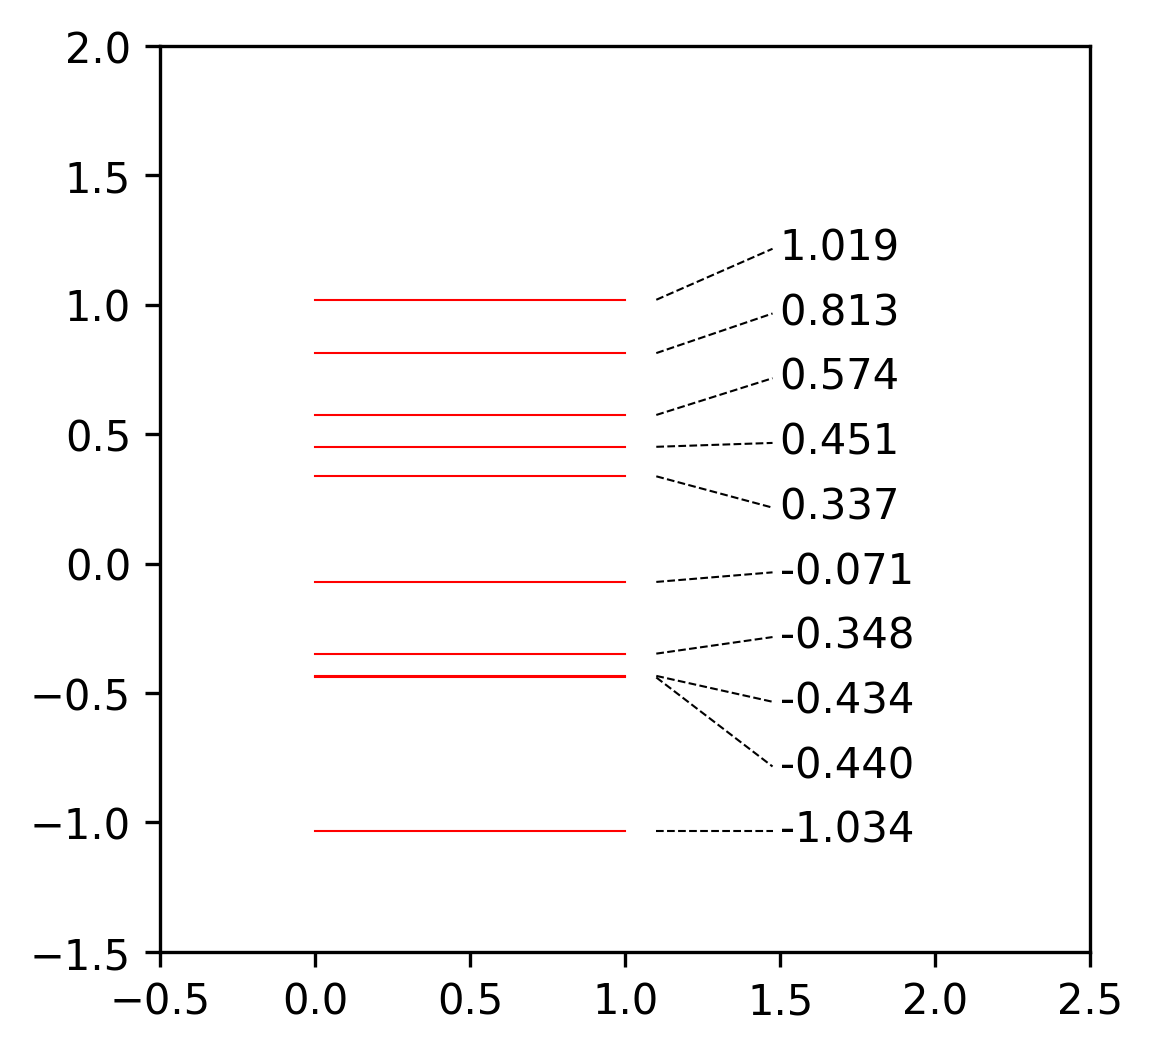

In [6]:
###
### Plot the energy spectrum:
###
plt.figure(figsize=(4, 4), dpi=300)

# Do some work on the energies:
tmp_ens = []
for phi_val in sorted_e_values:
    tmp_ens.append(round(np.log(phi_val).imag,3))
ens_ = np.unique(tmp_ens)
label_y = []
prev_en = None


for en_ in ens_:
    
    plt.plot([0,1],[en_, en_],  'r-', linewidth=0.5)
    
    if label_y:
        if en_ - prev_en > 0.25:
            label_y.append(label_y[-1] + 0.25)
        else:
            label_y.append(en_)
    else:
        label_y.append(en_)
        prev_en = en_
    

    plt.plot([1.1, 1.475], [en_, label_y[-1]], 'k--', linewidth=0.5)
    plt.text(1.5, label_y[-1]-0.0425, f'{en_.real:0.3f} ')
        

plt.xlim([-0.5, 2.5])
plt.ylim([-1.5, 2])